# Understanding the Amazon from Space

Pretrain neural network using Amazon satellite images from old Kaggle [competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). In order to used the trained weight for the Oil Palm [competition](https://www.kaggle.com/c/widsdatathon2019/leaderboard). This problem is originally a multi-class classification problem. I changed it to a single class classification problem to make the pretrained weights similar to the Oil Palm compeition.

In [1]:
#setup the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.greedy=True

import sys
import feather
from pathlib import Path
from glob import glob
sys.path.append(r'C:\Users\Benny\fastai\old')

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.plots import *

In [2]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

In [3]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is FC06-B52C

 Directory of C:\Users\Benny\Documents\Fern\planet

03/02/2019  02:42 PM    <DIR>          .
03/02/2019  02:42 PM    <DIR>          ..
03/02/2019  02:39 PM    <DIR>          .ipynb_checkpoints
03/02/2019  02:34 PM           600,968 lesson2-image_models.ipynb
03/02/2019  02:42 PM             1,962 planet.ipynb
03/02/2019  01:01 PM    <DIR>          train
02/28/2019  02:34 PM         1,432,177 train_v2.csv
               3 File(s)      2,035,107 bytes
               4 Dir(s)  13,857,865,728 bytes free


In [5]:
df = pd.read_csv('train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


## Modify Classes

There are 17 classes in this problems. Some are related to the weather, and some are not related to agriculture vs forest. These classes are dropped.

In [6]:
# drop all irrelvant classes 
to_drop = ['clear', 'cloudy', 'haze', 'partly_cloudy',
          'conventional_mine', 'artisinal_mine', 'habitation',
          'road', 'water', 'selective_logging','slash_burn']

#change all argriculture area to 1
to_arg = ['cultivation']

# change all non-argriculture to 0
to_primary = ['bare_ground', 'blooming', 'blow_down']

In [10]:
df_mod = df.copy()
    
for word in to_arg:
    df_mod['tags'] = df_mod['tags'].str.replace(word,'agriculture')

for word in to_primary:
    df_mod['tags'] = df_mod['tags'].str.replace(word,'primary')

In [31]:
len(df_mod)

40479

In [45]:
df_mod.head()

,image_name,tags,is_arg,is_forest
0,train_0,haze primary,False,True
1,train_1,agriculture clear primary water,True,True
2,train_2,clear primary,False,True
3,train_3,clear primary,False,True
4,train_4,agriculture clear habitation primary road,True,True


In [38]:
df_mod['is_arg'] = df_mod['tags'].str.contains('agriculture')
df_mod['is_forest'] = df_mod['tags'].str.contains('primary')
idxs = df_mod[(df_mod['is_arg'] == False) & (df_mod['is_forest'] == False)].index.values

In [40]:
df_mod.drop(idxs, axis=0, inplace=True), len(df_mod)

(None, 37995)

In [46]:
df_mod = df_mod.drop('tags', axis=1)

In [47]:
df_mod = df_mod.drop('is_forest', axis=1)

In [51]:
df_mod['is_arg'] = df_mod['is_arg'].astype(int)

In [54]:
df_mod.info(), df_mod.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37995 entries, 0 to 40478
Data columns (total 2 columns):
image_name    37995 non-null object
is_arg        37995 non-null int32
dtypes: int32(1), object(1)
memory usage: 742.1+ KB


(None,   image_name  is_arg
 0    train_0       0
 1    train_1       1
 2    train_2       0
 3    train_3       0
 4    train_4       1)

In [55]:
df_mod.to_csv('train_single.csv',index=False)

## Train a NN

In [3]:
df_mod = pd.read_csv('train_single.csv')
df_mod.head()

,image_name,is_arg
0,train_0,0
1,train_1,1
2,train_2,0
3,train_3,0
4,train_4,1


In [4]:
idxs = get_cv_idxs(len(df_mod), val_pct=0.05, seed=52)
len(idxs)

1899

In [71]:
print(df_mod.iloc[idxs]['is_arg'].value_counts())
print(df_mod.loc[~df_mod.index.isin(idxs)]['is_arg'].value_counts())

0    2428
1    1371
Name: is_arg, dtype: int64
0    22152
1    12044
Name: is_arg, dtype: int64


In [5]:
arch = resnext101 #plan with resnext101 or dn201
sz = 128
bs = 10

In [6]:
aug_tfms = transforms_top_down

In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.05)
data = ImageClassifierData.from_csv('', 'train', 'train_single.csv', bs=bs, tfms=tfms,suffix='.jpg',
                                    val_idxs=idxs, continuous=False, skip_header=True, num_workers=8, cat_separator=',')

In [10]:
%config IPCompleter.greedy=True

In [17]:
x, _ = next(iter(data.trn_dl))
img = data.trn_ds.denorm(to_np(x))[0]

In [18]:
img.shape

(128, 128, 3)

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:19<00:00,  7.80it/s]



 69%|█████████████████████████████████████████████▍                    | 2487/3610 [00:11<00:07, 153.43it/s, loss=1.29]

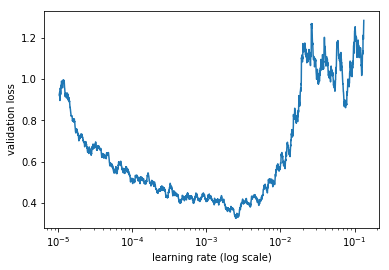

In [9]:
#learning rate finder
lrf=learn.lr_find()
learn.sched.plot()

In [10]:
lr = 2e-5
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.476359   0.349768   0.874671  
    1      0.391839   0.316619   0.88415                                                                               
    2      0.48146    0.304126   0.888362                                                                              
    3      0.433937   0.29617    0.888889                                                                              
    4      0.370368   0.288049   0.888889                                                                              
    5      0.359131   0.289188   0.889415                                                                              
    6      0.401924   0.29479    0.888889                                                                              


[0.29479039786457073, 0.8888888821719885]

In [12]:
lrs = np.array([lr/9,lr/3,lr])

In [13]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.348769   0.274213   0.886783  
    1      0.350279   0.268811   0.889942                                                                              
    2      0.351396   0.267629   0.893628                                                                              
    3      0.315701   0.2637     0.890469                                                                              
    4      0.333657   0.265173   0.895208                                                                              
    5      0.3177     0.260399   0.895208                                                                              
    6      0.322538   0.270528   0.892048                                                                              


[0.27052777644645043, 0.8920484390178437]

In [13]:
lr = 1e-5
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.439524   0.410666   0.800474  
    1      0.441772   0.342032   0.849171                                                                              
    2      0.42314    0.359413   0.828902                                                                              
    3      0.395329   0.332802   0.848908                                                                              
    4      0.350468   0.323857   0.857068                                                                              
    5      0.391015   0.313847   0.866017                                                                              
    6      0.384389   0.31262    0.861543                                                                              



[0.31261991118758753, 0.8615425057899453]

In [14]:
learn.save(arch.__name__+'planet_single')

In summary, I use the Amazon satellite image problem to pretrain a CNN architecture. In order to make the weights the same, I convert the multi-class classification problem into a binary classification problem by dropping some labels and data. Only label images with or without agriculture. The pretrain weight should be useful for training the oil palm satellite images. 